In [1]:
print('Kernel Initialized')

Kernel Initialized


In [2]:
# Imports
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import random
from utils import Utils
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn-v0_8-whitegrid")
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import mplhep as hep
hep.style.use(hep.style.ATLAS)
import scipy
from iminuit import Minuit
import toml


config = toml.load('config.toml')
Storage = Utils.HDF5_IO(config['PATHS']['Storage'])

In [11]:
Fit_path = r'/groups/hep/kvh318/RK_Star_Analysis/RKStar_Analysis/data/ResBd_Highq2_for_fit.ftr'
for_fit = pd.read_feather(Fit_path)

# Global Plot setting:

THRESHOLD1 = 0.9
THRESHOLD2 = 0.9
FIT_CASE = 1

columnNAME = Fit_path.split('/')[-1].split('_')[0]
for_fitfor_fit_w_cut = for_fit[[f"{columnNAME}MC_{THRESHOLD1},{THRESHOLD2}", f"{columnNAME}Data_{THRESHOLD1},{THRESHOLD2}"]]
MC_signal= for_fitfor_fit_w_cut.iloc[:,0].dropna()
Data_cutted= for_fitfor_fit_w_cut.iloc[:,1].dropna()

In [12]:
def gauss_pdf(x, mu, sigma):
    # Gaussian
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

def Bukin_pdf(x,Xp,sigmap,xi,rho1,rho2):
    # Xp = peak position
    # sigmap = FWHM divided by 2*sqrt(2*log(2))=2.35
    # xi = peak asymmetry parameter
    # rho1 = parameter of the "left tail"
    # rho2 = parameter of the "right tail"
    
    hp=sigmap * 2*np.sqrt(2*np.log(2.0))
    r3=np.log(2.0)
    r4=np.sqrt(xi*xi+1)
    r1=xi/r4

    r5 = np.where((np.abs(xi) > np.exp(-6.)),xi/np.log(r4+xi),1)

    x1 = Xp + (hp / 2) * (r1-1)
    x2 = Xp + (hp / 2) * (r1+1)

    condition_left = (x < x1)
    condition_center1 = ((x < x2) & ((np.abs(xi) > np.exp(-6.0))))
    condition_center2 = ((x < x2) & ((np.abs(xi) <= np.exp(-6.0))))
    condition_right = (~(condition_left & condition_center1 & condition_center2))

    # Left Side
    left=rho1*(x-x1)*(x-x1)/(Xp-x1)/(Xp-x1)-r3 + 4 * r3 * (x-x1)/hp * r5 * r4/(r4-xi)/(r4-xi)

    #Center
    center1=-r3*np.power(np.log(1 + 4 * xi * r4 * (x-Xp)/hp)/np.log(1+2*xi*(xi-r4)),2)
        
    center2=-4*r3*(x-Xp)*(x-Xp)/hp/hp
    
    # Right Side
    right=rho2*(x-x2)*(x-x2)/(Xp-x2)/(Xp-x2)-r3 - 4 * r3 * (x-x2)/hp * r5 * r4/(r4+xi)/(r4+xi)

    result=np.select([condition_left, condition_center1,condition_center2,condition_right], [left, center1, center2, right])
    
    fit_result = np.where((np.abs(result) <= 100), np.exp(result), 0)
    
    return fit_result 

def double_sided_crystal_ball(x, mu, width, a1, p1, a2, p2):
    u   = (x-mu)/width
    A1  = np.power(p1/np.abs(a1),p1)*np.exp(-a1*a1/2)
    A2  = np.power(p2/np.abs(a2),p2)*np.exp(-a2*a2/2)
    B1  = p1/np.abs(a1) - np.abs(a1)
    B2  = p2/np.abs(a2) - np.abs(a2)

    left_condition = (u<-a1)
    center_condition = (u<a2)
    right_condition = (~(left_condition & center_condition))

    left = A1*np.power(B1-u,-p1)
    center = np.exp(-u*u/2)
    right = A2*np.power(B2+u,-p2)

    result=np.select([left_condition, center_condition, right_condition], [left, center, right])
    return result

def tanh_pdf(x,scale,offset):
    # Tanh PDF with offset and scaling factor
    return np.tanh(scale * (x - offset) ) + 1.0
    
def CB_pdf(x, beta, m, mu=0, sigma=1):
    return scipy.stats.crystalball.pdf(x, beta, m, loc=mu, scale=sigma)

def gauss_plus_CB(x,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gauss):
    doubleGauss = frac_gauss * gauss_pdf(x,Sig_Peak,sigma_1) + (1-frac_gauss) * CB_pdf(x,Sig_Peak,sigma_2)

def doubleGauss_Bukin_pdf(x,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gauss,frac_bukin):
    doubleGauss = frac_gauss * gauss_pdf(x,Sig_Peak,sigma_1) + (1-frac_gauss) * gauss_pdf(x,Sig_Peak,sigma_2)
    doubleGauss_Bukin_pdf = frac_bukin * doubleGauss + (1-frac_bukin) * Bukin_pdf(x,Sig_Peak,sigmap,xi,rho1,rho2)
    return doubleGauss_Bukin_pdf

#def signal_fit(x,N_sig,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gaus,frac_bukin):
#    return N_sig * binwidth * doubleGauss_Bukin_pdf(x,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gaus,frac_bukin)


if FIT_CASE == 1:

    def signal_fit(x,N_sig,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gauss,frac_bukin):
        return N_sig * binwidth * doubleGauss_Bukin_pdf(x,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gauss,frac_bukin)

    def background_fit(x,N_bkg,scale,offset):
        return N_bkg * binwidth * tanh_pdf(x,scale,offset)

    def Sig_Bkg_fit(x,N_sig,N_bkg,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gauss,frac_bukin,scale,offset):
        Sig = signal_fit(x,N_sig,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gauss,frac_bukin)
        Bkg = background_fit(x,N_bkg,scale,offset)
        return Sig + Bkg


if FIT_CASE == 2:
    def signal_fit(x,N_sig,Sig_Peak, sigma_1, a1, p1, a2, p2,sigma_2,sigma_3,frac_gauss1, frac_gauss2):
        DSCB = double_sided_crystal_ball(x, Sig_Peak, sigma_1, a1, p1, a2, p2)
        Gauss1 = gauss_pdf(x,Sig_Peak,sigma_2)
        Gauss2 = gauss_pdf(x,Sig_Peak,sigma_3)
        dobule_gauss = (frac_gauss1 * Gauss1 + (1-frac_gauss1)*Gauss2)
        return N_sig * binwidth * (frac_gauss2 * DSCB + (1-dobule_gauss)*Gauss1)

    def background_fit(x,N_bkg,scale,offset):
        return N_bkg * binwidth * tanh_pdf(x,scale,offset)

    def Sig_Bkg_fit(x,N_sig,N_bkg,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gaus,frac_bukin,scale,offset):
        Sig = signal_fit(x,N_sig,Sig_Peak,sigma_1,sigma_2,sigmap,xi,rho1,rho2,frac_gaus,frac_bukin)
        Bkg = background_fit(x,N_bkg,scale,offset)
        return Sig + Bkg


signal_fit

<function __main__.signal_fit(x, N_sig, Sig_Peak, sigma_1, sigma_2, sigmap, xi, rho1, rho2, frac_gauss, frac_bukin)>

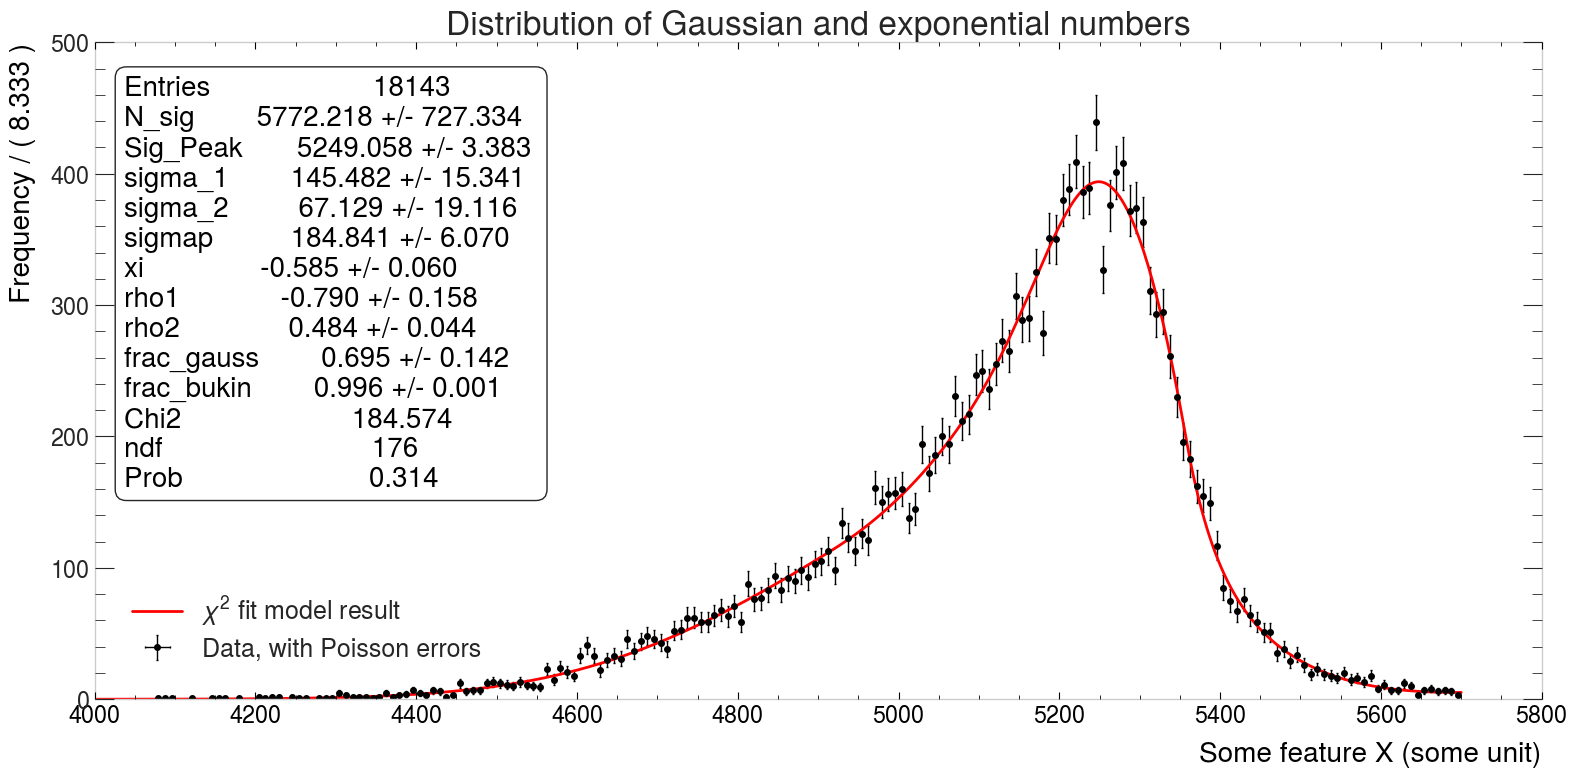

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 184.6                      │             Nfcn = 2597              │
│ EDM = 8.8e-10 (Goal: 0.0002)     │            time = 0.6 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_sig      │   5.8e3   │   0.7e3   │            │            │    0    │         │       │
│ 1 │ Sig_Peak   │ 5.2491e3  │ 0.0034e3  │            │            │  5000   │  5500   │       │
│ 2 │ sigma_1    │    145    │    15     │            │            │    0    │         │       │
│ 3 │ sigma_2    │    67     │    19     │            │            │    0    │         │       │
│ 4 │ sigmap     │    185    │     6     │            │            │    0    │         │       │
│ 5 │ xi         │   -0.58   │   0.06    │            │            │   -1    │    1    │       │
│ 6 │ rho1       │   -0.79   │   0.16    │            │            │   -1    │    0    │       │
│ 7 │ rho2       │   0.48    │   0.04    │            │            │    0    │    1    │       │
│ 8 │ frac_gauss │   0.69    │   0.14    │            │            │    0    │    1    │       │
│ 9 │ frac_bukin │ 995.5e-3  │  0.8e-3   │            │            │    0    │    1    │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│            │      N_sig   Sig_Peak    sigma_1    sigma_2     sigmap         xi       rho1       rho2 frac_gauss frac_bukin │
├────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│      N_sig │   5.29e+05        357   6.41e+03   9.61e+03    1.6e+03      -37.9      -89.9       13.7      -43.1        0.6 │
│   Sig_Peak │        357       11.4       6.43       8.72      -11.5     -0.117     0.0367     0.0392     0.0547   0.000121 │
│    sigma_1 │   6.41e+03       6.43        235        264      0.572     -0.418     -0.618     -0.186      -2.02    0.00693 │
│    sigma_2 │   9.61e+03       8.72        264        365       7.45     -0.672      -1.16    -0.0258       -2.4     0.0105 │
│     sigmap │    1.6e+03      -11.5      0.572       7.45       36.8    -0.0243     -0.768     0.0712     -0.123    0.00244 │
│         xi │      -37.9     -0.117     -0.418     -0.672    -0.0243    0.00366    0.00636   -0.00152    0.00179  -4.09e-05 │
│       rho1 │      -89.9     0.0367     -0.618      -1.16     -0.768    0.00636     0.0265   -0.00399    0.00469  -0.000111 │
│       rho2 │       13.7     0.0392     -0.186    -0.0258     0.0712   -0.00152   -0.00399    0.00192    0.00218    1.6e-05 │
│ frac_gauss │      -43.1     0.0547      -2.02       -2.4     -0.123    0.00179    0.00469    0.00218     0.0208  -4.93e-05 │
│ frac_bukin │        0.6   0.000121    0.00693     0.0105    0.00244  -4.09e-05  -0.000111    1.6e-05  -4.93e-05   6.96e-07 │
└────────────┴─────────────────────────────────────────────────────────────────

In [21]:
sig_fit_config = {}

# General input:
sig_fit_config['Nbins']=12*17
sig_fit_config['xrange'] = (4000,5700)
sig_fit_config['binwidth'] = (sig_fit_config['xrange'][1]-sig_fit_config['xrange'][0])/sig_fit_config['Nbins']


counts, bin_edges = np.histogram(MC_signal, bins=sig_fit_config['Nbins'], range=sig_fit_config['xrange'])
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.  
mask = y>0
y = y[mask]
sy = sy[mask]
x = x[mask]

binwidth = sig_fit_config['binwidth']
minuit_signal_chi2_object = Utils.Chi2Regression(signal_fit, x, y,sy,bound=sig_fit_config['xrange']) 

Init_sig_fit = {
    'N_sig':       [5000,0,None,False],
    'Sig_Peak':    [5279.64,5000,5500,False],
    'sigma_1':     [100,0,None,False],
    'sigma_2':     [300,0,None,False],
    'sigmap':      [200,0,None,False],
    'xi':          [-0.5,-1,1,False],
    'rho1':        [-0.5,-1,0,False],
    'rho2':        [0.5,0,1,False],
    'frac_gauss':   [0.5,0,1,False],
    'frac_bukin':  [0.5,0,1,False],
}
"""
Init_sig_fit = {
    'N_sig':       [400,0,None,False],
    'Sig_Peak':    [5279.64,5000,5500,False],
    'sigma_1':     [10,0,None,False],
    'a1':     [4.9714e-1,0,None,False],
    'p1':      [1.2617e2,0,None,False],
    'a2':          [1.6314e2,0,None,False],
    'p2':        [20,0,None,False],
    'sigma_2':        [20,0,None,False],
    'sigma_3':        [20,0,None,False],
    'frac_gauss1':   [0.5,0,1,False],
    'frac_gauss2':   [0.5,0.05,1,False],
}
"""
iminut_initializer_sig = Utils.iminut_value_initializer(Init_sig_fit,signal_fit)

minuit_signal_chi2 = Minuit(minuit_signal_chi2_object, *iminut_initializer_sig.init_values(), name = iminut_initializer_sig.names())
minuit_signal_chi2.errordef = Minuit.LEAST_SQUARES     # Value for likelihood fits
iminut_initializer_sig.limits_and_fixed(minuit_signal_chi2)

minuit_signal_chi2.simplex()
minuit_signal_chi2.migrad()           
#minuit_signal_chi2.scan(8000)
minuit_signal_chi2.migrad(ncall=1000,iterate=100)           
minuit_signal_chi2.migrad()           
minuit_signal_chi2.migrad()           
minuit_signal_chi2.hesse()   # accurately computes uncertainties



if (not minuit_signal_chi2.fmin.is_valid) :
    print("  WARNING: The Unbinned Likelihood fit DID NOT converge!!! ")

sig_fit_config['origin_fit'] = {
    'MLLH': minuit_signal_chi2.fval,
    'fit_values': minuit_signal_chi2.values,
    'fit_errors': minuit_signal_chi2.errors,
    'Minuit_object': minuit_signal_chi2
}

# Create just a single figure and axes, along with a histogram with uncertainties:
fig, ax = plt.subplots(figsize=(16, 8))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Some feature X (some unit)", # the label of the y axis
       ylabel=f"Frequency / ( {sig_fit_config['binwidth']:.3f} )",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

# Adding fit function to plot:
x_axis = np.linspace(sig_fit_config['xrange'][0], sig_fit_config['xrange'][1], 1000)
ax.plot(x_axis, signal_fit(x_axis, *sig_fit_config['origin_fit']['fit_values'][:]), '-r', label=r'$\chi^2$ fit model result') 

# Get Chi2 value:
chi2_value = minuit_signal_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_signal_chi2.nfit
Prob_value = scipy.stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom

# Adding fit results to plot:
d = {'Entries': counts.sum()}
for name in sig_fit_config['origin_fit']['Minuit_object'].parameters:
    value, error = sig_fit_config['origin_fit']['Minuit_object'].values[name], sig_fit_config['origin_fit']['Minuit_object'].errors[name]
    d[name] = [value,error]

d['Chi2']= chi2_value
d['ndf']= Ndof_value
d['Prob']= Prob_value


text = Utils.nice_string_output(d, extra_spacing=3, decimals=3)
Utils.add_text_to_ax(0.02, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.
fig.tight_layout()
plt.savefig(config['PATHS']['figure_save']+"pre-fit",bbox_inches = 'tight')

plt.show()
sig_fit_config['origin_fit']['Minuit_object']

# Total Plot with both Sig + Bkg

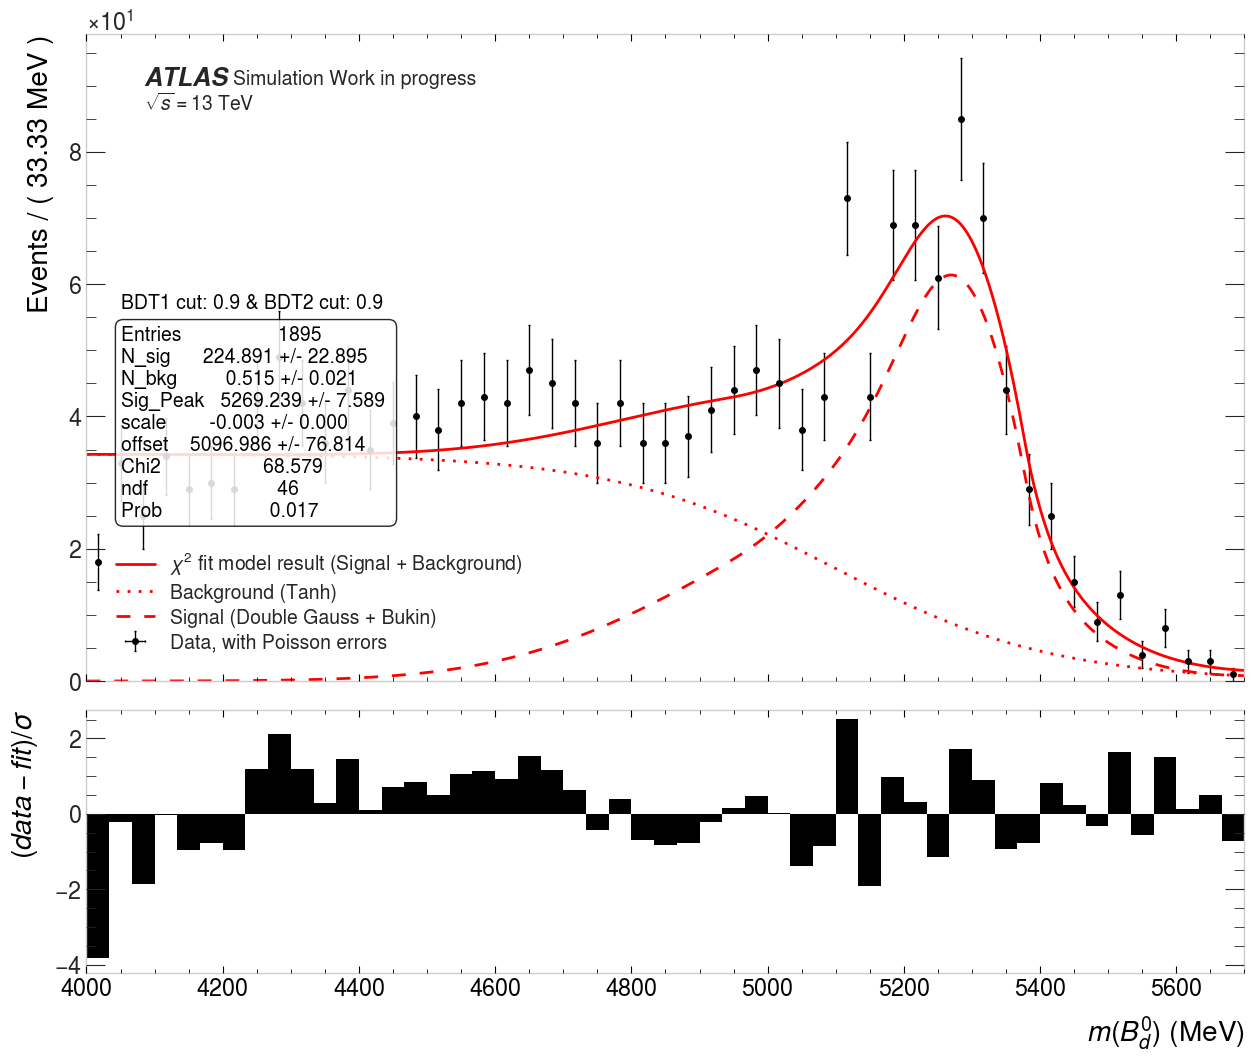

In [15]:
total_fit_config = {}
total_fit_config['Nbins']=3*17
total_fit_config['xrange'] = (4000,5700)
total_fit_config['binwidth'] = (total_fit_config['xrange'][1]-total_fit_config['xrange'][0])/total_fit_config['Nbins']
binwidth = total_fit_config['binwidth']

counts, bin_edges = np.histogram(Data_cutted, bins=total_fit_config['Nbins'], range=total_fit_config['xrange'])
#counts, bin_edges = np.histogram(Data_cutted, bins=histedges_equalN(Data_cutted, total_fit_config['Nbins']), range=total_fit_config['xrange'])

x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)   # NOTE: We (naturally) assume that the bin count is Poisson distributed.
                       # This is an approximation, since there is a low count in the last bins.  
mask = y>0
y = y[mask]
sy = sy[mask]
x = x[mask]

Init_total_fit = {
    'N_sig':       [2000,0,None,False],
    'N_bkg':       [1000,0,None,False],
    'Sig_Peak':    [sig_fit_config['origin_fit']['fit_values']['Sig_Peak'],sig_fit_config['origin_fit']['fit_values']['Sig_Peak']-50, sig_fit_config['origin_fit']['fit_values']['Sig_Peak']+50,False],
    'sigma_1':     [sig_fit_config['origin_fit']['fit_values']['sigma_1'],0,None,True],
    'sigma_2':     [sig_fit_config['origin_fit']['fit_values']['sigma_2'],0,None,True],
    'sigmap':      [sig_fit_config['origin_fit']['fit_values']['sigmap'],0,None,True],
    'xi':          [sig_fit_config['origin_fit']['fit_values']['xi'],-1,1,True],
    'rho1':        [sig_fit_config['origin_fit']['fit_values']['rho1'],-1,0,True],
    'rho2':        [sig_fit_config['origin_fit']['fit_values']['rho2'],0,1,True],
    'frac_gauss':   [sig_fit_config['origin_fit']['fit_values']['frac_gauss'],0,1,True],
    'frac_bukin':  [sig_fit_config['origin_fit']['fit_values']['frac_bukin'],0,1,True],
    'scale':       [-0.00211,-0.1, -0.00001,False],
    'offset':      [5100,4000,5500,False],
}
iminut_initializer_total = Utils.iminut_value_initializer(Init_total_fit,Sig_Bkg_fit)

minuit_total_chi2_object = Utils.Chi2Regression(Sig_Bkg_fit, x, y,sy,bound=total_fit_config['xrange']) 
minuit_total_chi2 = Minuit(minuit_total_chi2_object, *iminut_initializer_total.init_values(), name = iminut_initializer_total.names())
minuit_total_chi2.errordef = Minuit.LEAST_SQUARES     # Value for likelihood fits
iminut_initializer_total.limits_and_fixed(minuit_total_chi2)

minuit_total_chi2.simplex()
minuit_total_chi2.migrad()           
#minuit_total_chi2.scan(8000)
minuit_total_chi2.migrad(ncall=1000,iterate=100)           
minuit_total_chi2.migrad()           
minuit_total_chi2.migrad()           
minuit_total_chi2.hesse()   # accurately computes uncertainties

if (not minuit_total_chi2.fmin.is_valid) :
    print("  WARNING: The Unbinned Likelihood fit DID NOT converge!!! ")

total_fit_config['origin_fit'] = {
    'MLLH': minuit_total_chi2.fval,
    'fit_values': minuit_total_chi2.values,
    'fit_errors': minuit_total_chi2.errors,
    'Minuit_object': minuit_total_chi2
}




# Create just a single figure and axes, along with a histogram with uncertainties:
fig = plt.figure(figsize=(12,10))

ax_main = fig.add_subplot(111)
ax_main.axis('off')  # command for hiding the axis.

Sub_top = inset_axes(ax_main, width="100%", height="67.5%", loc=9)
Sub_bottom = inset_axes(ax_main, width="100%", height="27.5%", loc=8)
Sub_top.set_xticks([])
Sub_top.sharex(Sub_bottom)
Sub_top.tick_params(labelbottom=False)
Sub_top.spines['bottom'].set_visible(True)
#Sub_top.set_title(title)
Sub_top.set_ylim(0,np.max(y)*1.15)
Sub_top.set_xlim(total_fit_config['xrange'])
#Sub_top.legend(loc='upper left',frameon=True)
Sub_bottom.set_xlabel(f"$m(B_d^0)$ (MeV)",loc='right')
Sub_top.set_ylabel(f"Events / ( {total_fit_config['binwidth']:.2f} MeV )",loc='top')
Sub_bottom.set_ylabel(rf"$(data-fit)/\sigma$",loc='top')

#Sub_bottom.legend(loc = 'lower left', frameon=True,fontsize=8,ncol=2)
Sub_top.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
Sub_bottom.set_xlim(total_fit_config['xrange'])

Sub_top.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Adding fit function to plot:
x_axis = np.linspace(total_fit_config['xrange'][0], total_fit_config['xrange'][1], 1000)
Sub_top.plot(x_axis, Sig_Bkg_fit(x_axis, *total_fit_config['origin_fit']['fit_values'][:]), '-r', label=r'$\chi^2$ fit model result (Signal + Background)') 
Sub_top.plot(x_axis, background_fit(x_axis, *total_fit_config['origin_fit']['fit_values'][[1,11,12]]), '-r', label='Background (Tanh)',ls=(0,(1,3))) 
Sub_top.plot(x_axis, signal_fit(x_axis, *total_fit_config['origin_fit']['fit_values'][[0,2,3,4,5,6,7,8,9,10]]), '-r', label='Signal (Double Gauss + Bukin)',ls=(0,(5,5))) 

chi2_value=  total_fit_config['origin_fit']['Minuit_object'].fval  

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - total_fit_config['origin_fit']['Minuit_object'].nfit
Prob_value = scipy.stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom 

d_cut=f'BDT1 cut: {THRESHOLD1} & BDT2 cut: {THRESHOLD2}'
# Adding fit results to plot:
d = {'Entries': len(Data_cutted)}
for name in total_fit_config['origin_fit']['Minuit_object'].parameters:
    if total_fit_config['origin_fit']['Minuit_object'].fixed[name] == False:
        value, error = total_fit_config['origin_fit']['Minuit_object'].values[name], total_fit_config['origin_fit']['Minuit_object'].errors[name]
        d[name] = [value,error]
d['Chi2']= chi2_value
d['ndf']= Ndof_value
d['Prob']= Prob_value
        
hep.atlas.label('Work in progress',loc=4,ax=Sub_top)

text = Utils.nice_string_output(d, extra_spacing=2, decimals=3)
Utils.add_text_to_ax(0.03, 0.55, text, Sub_top, fontsize=14,border=True)
Utils.add_text_to_ax(0.03, 0.60, d_cut, Sub_top, fontsize=14,border=False)


Sub_top.legend(loc='lower left', fontsize=14); # could also be # loc = 'upper right' e.g.

resid = (y-Sig_Bkg_fit(x, *total_fit_config['origin_fit']['fit_values'][:]))/sy
Sub_bottom.bar(x,resid,width=np.full(len(x),total_fit_config['binwidth']),color='k',alpha=1)
Sub_bottom.set_ylim(-abs(np.min(resid))*1.1,np.max(resid)*1.1)


fig.tight_layout()
plt.savefig(config['PATHS']['figure_save']+"Full_fit_1",bbox_inches = 'tight')

fig.show()
